# Generate Data and Train Model

This notebook will generate a dataset of noisy images of playing cards (J, Q, K), train a model using these images, and plot the learning curve. The model and dataset will be tracked using DVC (Data Version Control).

## Table of Contents
1. [Setup](#setup)
2. [Generate Dataset](#generate-dataset)
3. [Train Model](#train-model)
4. [Plot Learning Curve](#plot-learning-curve)
5. [Save Model and Dataset](#save-model-and-dataset)
6. [Conclusion](#conclusion)

## Setup
First, ensure you have the necessary libraries installed. You may need to install DVC and scikit-learn if you haven't already:
```bash
conda install -c conda-forge dvc
conda install scikit-learn
```

### Import Required Libraries

In [1]:
import os
import datetime
import matplotlib.pyplot as plt # type: ignore
from model import build_model, train_model, evaluate_model
from data_sets import generate_data_set

### Configuration
Set paths and parameters for the data generation and model training

In [2]:
# Configuration
N_SAMPLES = 1000  # Number of samples to generate
n_validation = 200
NOISE_LEVELS = [0.0, 0.2, 0.5, 0.7, 0.9]  # Different noise levels to train the model on
MODEL_DIR = 'models'
DATASET_DIR = 'data_sets'

# Create directories for saving models and datasets
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)

def generate_model_name(base_name="model", extension="keras"):
    """
    Generate a unique model name using the current timestamp.

    Arguments
    ---------
    base_name : str
        The base name for the model file.
    extension : str
        The file extension for the model file.

    Returns
    -------
    str
        A unique model name with the current timestamp.
    """
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    return f"{base_name}_{timestamp}.{extension}"

## Generate Dataset
### Generate Testing and Training Images
Generate a dataset of images.

In [3]:
for noise_level in NOISE_LEVELS:
    noise_level_str = str(noise_level).replace('.', '_')  # Replace decimal point for file naming
    dataset_path = os.path.join(DATASET_DIR, f"dataset_noise_{noise_level_str}")
    
    # Create the base dataset directory
    os.makedirs(dataset_path, exist_ok=True)
    
    # Create subdirectories for training and test images
    training_images_path = os.path.join(dataset_path, 'training_images')
    test_images_path = os.path.join(dataset_path, 'test_images')
    
    # Create the training and test images directories
    os.makedirs(training_images_path, exist_ok=True)
    os.makedirs(test_images_path, exist_ok=True)
    
    # Generate the dataset (for training and test)
    generate_data_set(N_SAMPLES, training_images_path)
    generate_data_set(N_SAMPLES, test_images_path)


## Train Model
### Training Function
Train the model on the generated datasets.

In [ ]:
training_histories = {}  # Store training histories for each noise level
scores = {}
model = build_model()  # Build a new keras model

for noise_level in NOISE_LEVELS:
    noise_level_str = str(noise_level).replace('.', '_')  # For consistent naming
    training_image_path = os.path.join(DATASET_DIR, f"dataset_noise_{noise_level_str}","training_images")
    test_image_path = os.path.join(DATASET_DIR, f"dataset_noise_{noise_level_str}","test_images")
    
    print(training_image_path)
    trained_model, history = train_model(model, training_image_path, n_validation, write_to_file=False)
    
    # Save the trained model
    model_version = generate_model_name()
    trained_model.save(os.path.join(MODEL_DIR, model_version))
    
    # Store history
    training_histories[noise_level_str] = history
    
    # Evaluate the model on the test set and store the score
    score = evaluate_model(trained_model, test_image_path)
    scores[noise_level_str] = score  # Store the test score
    
    print(f"training history for noise level {noise_level_str} include: {training_histories[noise_level_str]}")
    print(f"score for noise level {noise_level_str} is: {scores[noise_level_str]}")


## Plot Learning Curve
### Visualize Training History
Plot the learning curve for accuracy and loss over epochs for each noise level.

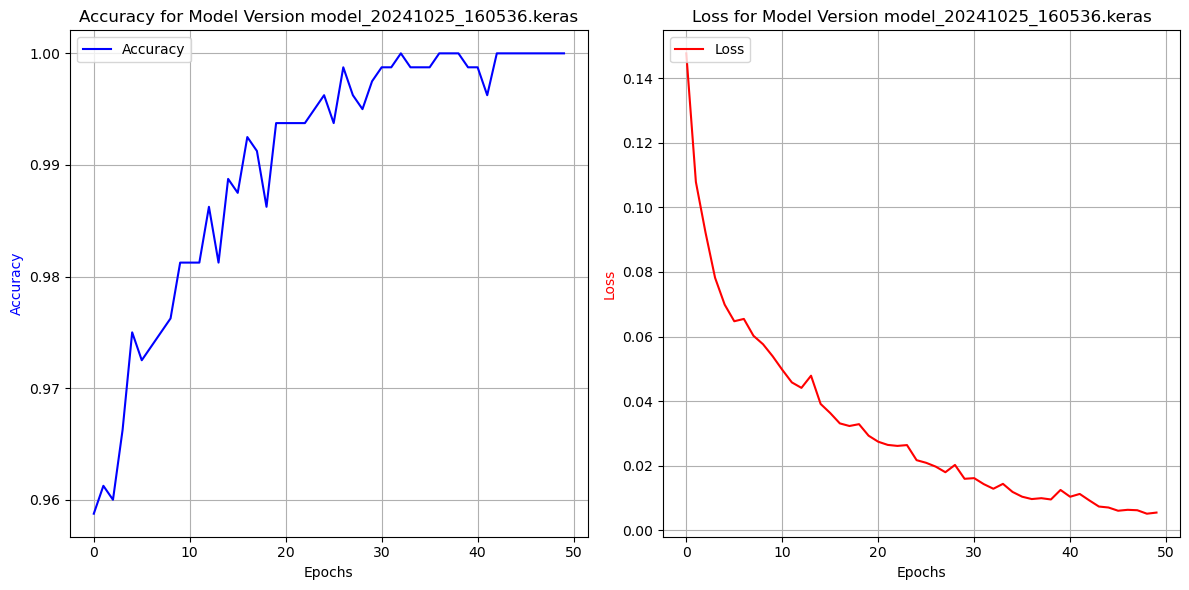

In [5]:
# Get the last noise level and its corresponding history
last_noise_level_str = list(training_histories.keys())[-1]
last_history = training_histories[last_noise_level_str]

# Set up subplots: 1 row, 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot accuracy
ax1.plot(last_history.history['accuracy'], label='Accuracy', color='blue')
ax1.set_title(f'Accuracy for Model Version {model_version}')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='blue')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot loss
ax2.plot(last_history.history['loss'], label='Loss', color='red')
ax2.set_title(f'Loss for Model Version {model_version}')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss', color='red')
ax2.legend(loc='upper left')
ax2.grid(True)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('learning_curves.png')  # Save the learning curve figure
plt.show()

## Save Model and Dataset
### DVC Tracking
Use DVC to track the datasets and models.

In [ ]:
# Initialize DVC if not already done
!dvc init

# Add dataset and model to DVC
!dvc add datasets
!dvc add models

### Commit Changes
Commit the changes to DVC to track versions.

In [9]:
# Commit changes to dvc remote repository at s3://pokerbot-29-dvc
!dvc push
!dvc status

Pushing
!
  0% Querying remote cache|                          |0/2 [00:00<?,    ?files/s]
                                                                                
!
  0% Checking cache in 'pokerbot-29-dvc/files/md5'|  |0/? [00:00<?,    ?files/s]
                                                                                
!
  0% Checking cache in '/Users/sadra/Documents/M.Sc./5ara0-softwareForAI/d/poker
md5: d751713988987e9331980363e24189ce.dir
Pushing
!
  0%|          |Pushing to s3                        0/12 [00:00<?,     ?file/s]
  0%|          |Pushing to s3                        0/11 [00:00<?,     ?file/s]

!

  0%|          |/Users/sadra/Documents/M.Sc./5a0.00/1.94M [00:00<?,        ?B/s]

100%|██████████|/Users/sadra/Documents/M.S1.94M/1.94M [00:02<00:00,     690kB/s]

                                                                                
  9%|▉         |Pushing to s3                    1/11 [00:03<00:29,  2.95s/file]

!

  0%|          |/Users/sadra/Docu

## Conclusion
In this notebook, we generated a dataset of noisy card images, trained a model on the generated images, and plotted the learning curves. The models and datasets were saved in structured directories and tracked using DVC for version control.

### Explanation of Each Section
- **Setup**: Initializes the necessary libraries and configuration settings, including directories for datasets and models.
- **Generate Dataset**: Loops through different noise levels to generate datasets, saving each in a separate folder.
- **Train Model**: Builds and trains a model for each noise level, saving the model files with appropriate names.
- **Plot Learning Curve**: Plots accuracy and loss curves for each noise level and saves the figure.
- **Save Model and Dataset**: Shows how to use DVC to track datasets and models, including initializing DVC, adding files, and committing changes.